# Client Enrollment Model

## Overview
Develop a segmentation model for our marketing department that predicts client enrollment. The target variable is whether a client has enrolled on the product (enroll=yes) or not (enroll=no). 

The following information is provided:
| Feature | Definition |
| --- | --- |
| customer_age | Age (in years) of the client |
| occupation | Type of employment |
| marital_status | Marital status |
| education_level | Education level |
| credit_in_default | Indicator for if the client has credit in default |
| housing_loan | Indicator for if the client has a housing loan |
| personal_loan | Indicator for if the client has a personal loan |
| contact_channel | Contact communication channel for the most recent contact of the campaign |
| month | month of the most recent contact with the client |
| day_of_week | Day of the week of the most recent contact with the client |
| number_contacts | Number of times the client was contacted during the campaign |
| number_days_since_last | Number of days since the client was last contacted from a prior campaign (999 means there was no prior contact to the client) |
| number_contacts_previous | Number of contacts to this client before the current campaign |
| enroll_previous | Result of the previous campaign |
| cpi | Monthly indicator of the Consumer Price Index |
| cci | Monthly indicator of the Consumer Confidence Index |
| enroll | Binary indicator for if the client has enrolled in the product |

## Environment
The package versions are listed in the requirements.txt file and the python version is listed below:

In [1]:
import sys
random_state = 13
print("python version " + sys.version)

python version 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]


## Load in Data
Data was provided via csv file.

In [2]:
# Read in the data
import pandas as pd

filepath = './data/data.csv'
with open(filepath, 'r') as f:
    raw_data = pd.read_csv(filepath)

raw_data.head()

,customer_age,occupation,marital_status,education_level,credit_in_default,housing_loan,personal_loan,contact_channel,month,day_of_week,number_contacts,number_days_since_last,number_contacts_previous,enroll_previous,cpi,cci,enroll
0,56,homemaker,married,basic,no,no,no,phone,may,M,1,999,0,does_not_exist,93.994,-36.4,no
1,57,services,married,high_school,unknown,no,no,phone,may,M,1,999,0,does_not_exist,93.994,-36.4,no
2,37,services,married,high_school,no,yes,no,phone,may,M,1,999,0,does_not_exist,93.994,-36.4,no
3,40,admin,married,basic,no,no,no,phone,may,M,1,999,0,does_not_exist,93.994,-36.4,no
4,56,services,married,high_school,no,no,yes,phone,may,M,1,999,0,does_not_exist,93.994,-36.4,no


No imputation needed since there are no missing values. Only consider capping max/min values.

In [3]:
# Check for nulls
raw_data.isnull().sum()

customer_age                0
occupation                  0
marital_status              0
education_level             0
credit_in_default           0
housing_loan                0
personal_loan               0
contact_channel             0
month                       0
day_of_week                 0
number_contacts             0
number_days_since_last      0
number_contacts_previous    0
enroll_previous             0
cpi                         0
cci                         0
enroll                      0
dtype: int64

Insights gathered from the numerical features using descriptive metrics:
1. Age:
    - Clients tend to be older as expected
2. number_contacts: 
    - Most customers have a low number of contacts this 
    - Perhaps binning would be useful
3. number_days_since_last: The 999 value hides the underlying distribution. Further analysis is necessary.
    - Creating a binary feature for participation in previous campaign might be helpful
    - Binning might also be useful
4. number_contacts_previous: Most clients were not previously contacted
    - Binary transformation is a possibility

In [4]:
# Examine percentiles and descriptive metrics
raw_data.describe()

,customer_age,number_contacts,number_days_since_last,number_contacts_previous,cpi,cci
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,93.575664,-40.502600
std,10.42125,2.770014,186.910907,0.494901,0.578840,4.628198
min,17.00000,1.000000,0.000000,0.000000,92.201000,-50.800000
25%,32.00000,1.000000,999.000000,0.000000,93.075000,-42.700000
50%,38.00000,2.000000,999.000000,0.000000,93.749000,-41.800000
75%,47.00000,3.000000,999.000000,0.000000,93.994000,-36.400000
max,98.00000,56.000000,999.000000,7.000000,94.767000,-26.900000


Insights from the categorical features using Descriptive analytics:
1. Some features are severely unbalanced and should be considered:
    - occupation
    - marital_status
    - education_level
    - credit_in_default
    - housing_loan
    - personal_loan
    - month
    - enroll_previous
    - enroll
2. There are some features that may benefit from introducing ordinality
    - education_level
    - month
    - day_of_week

In [5]:
# Examine descriptive metrics
raw_data.describe(include = 'object')

,occupation,marital_status,education_level,credit_in_default,housing_loan,personal_loan,contact_channel,month,day_of_week,enroll_previous,enroll
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,6,3,3,3,2,10,5,3,2
top,admin,married,basic,no,yes,no,email,may,R,does_not_exist,no
freq,10422,24928,12513,32588,21576,33950,26144,13769,8623,35563,36548


In [6]:
def describe_categorical_features(data: pd.DataFrame) -> None:
    n = len(data)
    for index, col in enumerate(data.select_dtypes('O').columns):
        print(f"{index}. {col}")
        values = []
        for value in data[col].unique():
            count = sum(data[col] == value)
            percentage = round(count/n*100, 2)
            values.append([value, percentage])
        
        sorted_values = sorted(values, key=lambda x: x[1], reverse=True)
        sorted_strings = [f"{value[0]} ({value[1]}%)" for value in sorted_values]
        print(f" => {', '.join(sorted_strings)}")

describe_categorical_features(raw_data)

0. occupation
 => admin (25.3%), blue_collar (22.47%), technician (16.37%), services (9.64%), management (7.1%), retired (4.18%), entrepreneur (3.54%), self_employed (3.45%), homemaker (2.57%), unemployed (2.46%), student (2.12%), unknown (0.8%)
1. marital_status
 => married (60.52%), single (28.09%), divorced (11.2%), unknown (0.19%)
2. education_level
 => basic (30.38%), college_degree (29.54%), high_school (23.1%), professional_training (12.73%), unknown (4.2%), illiterate (0.04%)
3. credit_in_default
 => no (79.12%), unknown (20.87%), yes (0.01%)
4. housing_loan
 => yes (52.38%), no (45.21%), unknown (2.4%)
5. personal_loan
 => no (82.43%), yes (15.17%), unknown (2.4%)
6. contact_channel
 => email (63.47%), phone (36.53%)
7. month
 => may (33.43%), jul (17.42%), aug (15.0%), jun (12.91%), nov (9.96%), apr (6.39%), oct (1.74%), sep (1.38%), mar (1.33%), dec (0.44%)
8. day_of_week
 => R (20.94%), M (20.67%), W (19.75%), T (19.64%), F (19.0%)
9. enroll_previous
 => does_not_exist (86.

Since there are many heavily unbalanced categorical features, K-Fold validation will be implemented in place of a separate validation dataset to increase probability that the rare options will be present in the training data.

In [7]:
# Separate train, validate, test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    raw_data.drop(['enroll'], axis=1),
    raw_data['enroll'],
    test_size=0.2,
    random_state=random_state)

raw_train = pd.concat([x_train, y_train], axis=1, sort=False).reset_index(drop=True)
raw_test = pd.concat([x_test, y_test], axis=1, sort=False).reset_index(drop=True)

del raw_data, x_train, x_test, y_train, y_test

print(f"Train: {len(raw_train)} records")
print(f"Test:  {len(raw_test)} records")

Train: 32950 records
Test:  8238 records


## Exploratory Data Analysis - Continuous

Most of the continuous variables are non-normal and have different variances which are required for a 2-sample t-test. A Mann-Whitney U-test will be used to supplement testing differences between the means of the enrollees and non-enrollees.

In [8]:
from scipy.stats import ttest_ind, normaltest, mannwhitneyu
import pandas as pd

def test_2_sample(pop1: pd.Series, pop2: pd.Series, threshold: float = 0.05, digits: int = 3) -> None:
    # Tests
    _, pop1_pval = normaltest(pop1)
    _, pop2_pval = normaltest(pop2)
    _, pval_t = ttest_ind(pop1, pop2)
    _, pval_mann = mannwhitneyu(pop1, pop2)

    # Results
    print("2-sample t-test Results")
    print("=======================")
    print("Population 1:")
    print(f" => Variance: {round(pop1.var(), digits)}")
    print(f" => Normality: P-value {round(pop1_pval.var(), digits)} | {'Not Normal' if pop1_pval < threshold else 'Normal'}")
    print("\nPopulation 2:")
    print(f" => Variance: {round(pop2.var(), digits)}")
    print(f" => Normality: P-value {round(pop2_pval.var(), digits)} | {'Not Normal' if pop2_pval < threshold else 'Normal'}")
    print("\n2-Sample T-test Result:")
    print(f" => P-value {round(pval_t, digits)} | {'Not Equal' if pval_t < threshold else 'Equal'}")
    print("\nMann-Whitney U-test Result:")
    print(f" => P-value {round(pval_mann, digits)} | {'Not Equal' if pval_mann < threshold else 'Equal'}")
    return None

train = raw_train

### Customer Age
For customer age, it seems like there are more clients above the age of 60 that enroll. Furthermore, as suggested by the Mann-Whitney test, there is a difference between the means of the 2 populations

2-sample t-test Results
Population 1:
 => Variance: 190.151
 => Normality: P-value 0.0 | Not Normal

Population 2:
 => Variance: 97.509
 => Normality: P-value 0.0 | Not Normal

2-Sample T-test Result:
 => P-value 0.0 | Not Equal

Mann-Whitney U-test Result:
 => P-value 0.009 | Not Equal


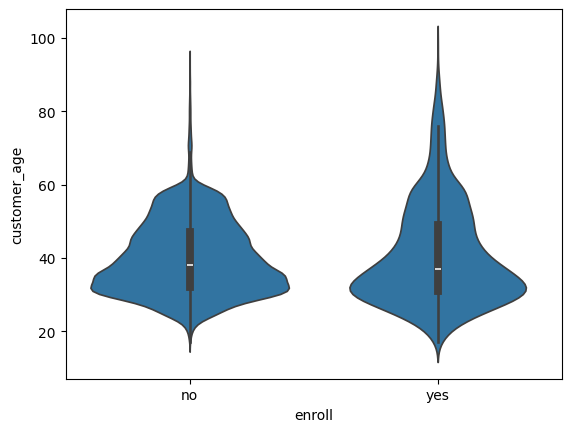

In [9]:
import seaborn as sns
sns.violinplot(data=train, x='enroll', y='customer_age')
test_2_sample(
    train[train['enroll'] == 'yes']['customer_age'],
    train[train['enroll'] == 'no']['customer_age']
)

### Number of Contacts
We can see a few outliers described in the summary statistics in the beginning. When controlling for extreme values, we see that that enrollees tend to have a lower number of contacts.

<Axes: xlabel='enroll', ylabel='number_contacts'>

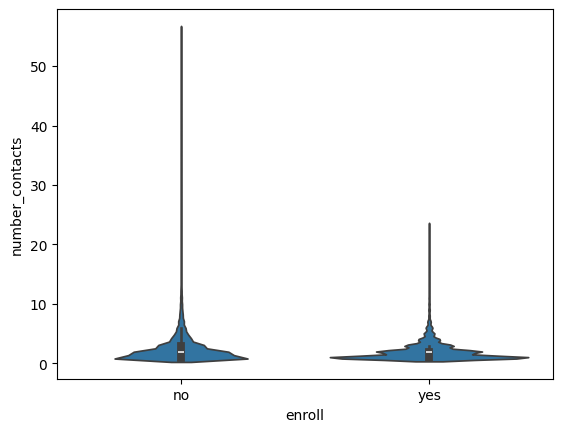

In [10]:
sns.violinplot(data=train, x='enroll', y='number_contacts')

2-sample t-test Results
Population 1:
 => Variance: 1.843
 => Normality: P-value 0.0 | Not Normal

Population 2:
 => Variance: 2.728
 => Normality: P-value 0.0 | Not Normal

2-Sample T-test Result:
 => P-value 0.0 | Not Equal

Mann-Whitney U-test Result:
 => P-value 0.0 | Not Equal


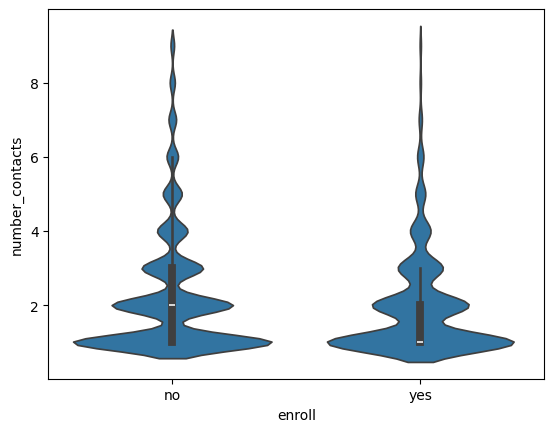

In [11]:
# Without outliers
sns.violinplot(
    data=train[train['number_contacts'] < 10],
    x='enroll',
    y='number_contacts'
)
test_2_sample(
    train[(train['enroll'] == 'yes') & (train['number_contacts'] < 10)]['number_contacts'],
    train[(train['enroll'] == 'no') & (train['number_contacts'] < 10)]['number_contacts']
)

### Number of days since last contact
No difference between the enrollees and the non-enrollees with respect to `number_days_since_last`. Creating a new feature to indicate participation in the previous campaign is useful.

2-sample t-test Results
Population 1:
 => Variance: 14.127
 => Normality: P-value 0.0 | Not Normal

Population 2:
 => Variance: 16.259
 => Normality: P-value 0.0 | Not Normal

2-Sample T-test Result:
 => P-value 0.144 | Equal

Mann-Whitney U-test Result:
 => P-value 0.265 | Equal


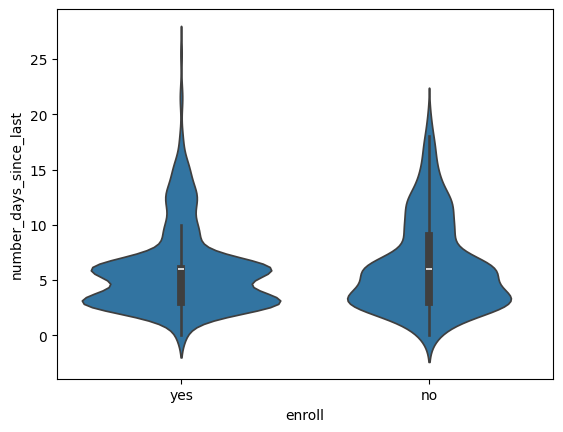

In [12]:
sns.violinplot(
    data=train[train['number_days_since_last'] < 999],
    x='enroll',
    y='number_days_since_last'
)

test_2_sample(
    train[(train['enroll'] == 'yes') & (train['number_days_since_last'] < 999)]['number_days_since_last'],
    train[(train['enroll'] == 'no') & (train['number_days_since_last'] < 999)]['number_days_since_last']
)

### Number of Previous Contacts
A difference between population means with respect to `number_contacts_previous` is supported visually and with a Mann-Whitney U-test

2-sample t-test Results
Population 1:
 => Variance: 0.729
 => Normality: P-value 0.0 | Not Normal

Population 2:
 => Variance: 0.253
 => Normality: P-value 0.0 | Not Normal

2-Sample T-test Result:
 => P-value 0.0 | Not Equal

Mann-Whitney U-test Result:
 => P-value 0.0 | Not Equal


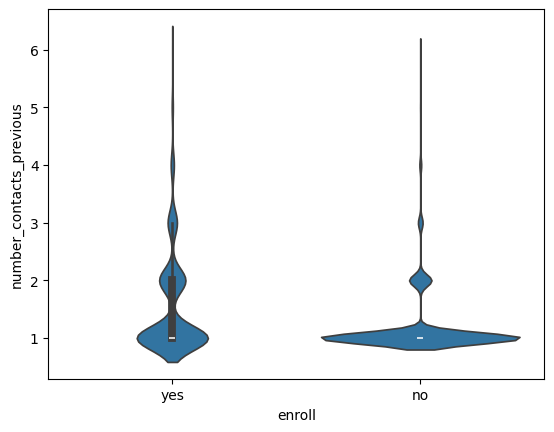

In [13]:
sns.violinplot(
    data=train[train['number_contacts_previous'] > 0],
    x='enroll',
    y='number_contacts_previous'
)
test_2_sample(
    train[(train['enroll'] == 'yes') & (train['number_contacts_previous'] > 0)]['number_contacts_previous'],
    train[(train['enroll'] == 'no') & (train['number_contacts_previous'] > 0)]['number_contacts_previous']
)

### CPI
A difference between population means with respect to `cpi` is supported visually. The Mann-Whitney supports this finding as well. More clients join below a cpi of 92.75.

2-sample t-test Results
Population 1:
 => Variance: 0.46
 => Normality: P-value 0.0 | Not Normal

Population 2:
 => Variance: 0.311
 => Normality: P-value 0.0 | Not Normal

2-Sample T-test Result:
 => P-value 0.0 | Not Equal

Mann-Whitney U-test Result:
 => P-value 0.0 | Not Equal


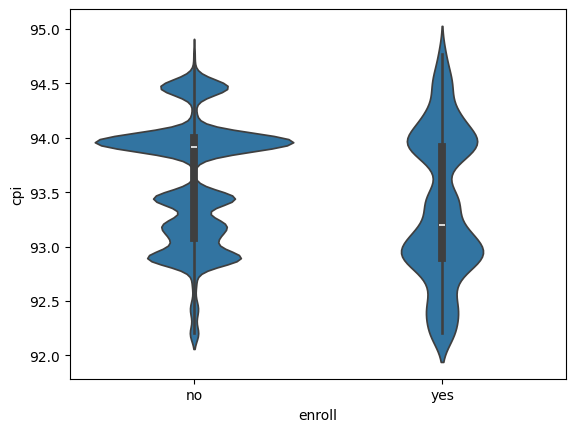

In [14]:
sns.violinplot(
    data=train,
    x='enroll',
    y='cpi'
)
test_2_sample(
    train[(train['enroll'] == 'yes')]['cpi'],
    train[(train['enroll'] == 'no')]['cpi']
)

### CCI
A difference between population means with respect to `cci` is supported visually. Mann-Whitney U-test is not taken into account due to the difference in the distribution shapes. Additionally, higher CCI tends to have more enrollments.

2-sample t-test Results
Population 1:
 => Variance: 37.461
 => Normality: P-value 0.0 | Not Normal

Population 2:
 => Variance: 19.264
 => Normality: P-value 0.0 | Not Normal

2-Sample T-test Result:
 => P-value 0.0 | Not Equal

Mann-Whitney U-test Result:
 => P-value 0.0 | Not Equal


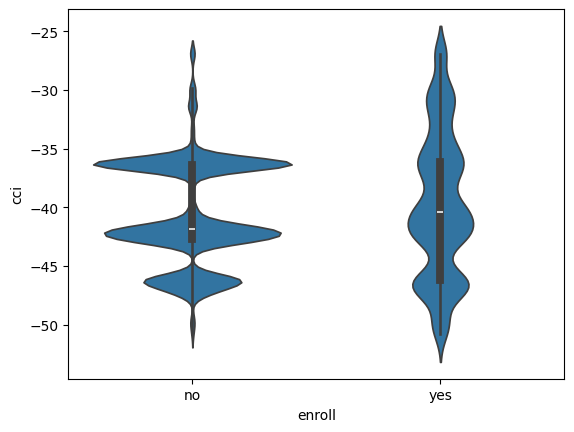

In [15]:
sns.violinplot(
    data=train,
    x='enroll',
    y='cci'
)
test_2_sample(
    train[(train['enroll'] == 'yes')]['cci'],
    train[(train['enroll'] == 'no')]['cci']
)

## Exploratory Data Analysis - Discrete

In [16]:
# Convert enroll to binary
train['enroll_binary'] = [1 if x == 'yes' else 0 for x in train['enroll']]
train['enroll_binary'].head()

0    0
1    0
2    0
3    0
4    1
Name: enroll_binary, dtype: int64

Since we are dummy encoding and performing feature selection, additional testing for the significance of each category after the chi-squared test for feature importance is not needed.

In [17]:
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import pandas as pd

def pivot(data: pd.DataFrame, variable: str, target: str) -> pd.DataFrame:
    cols = data.columns
    if variable not in cols or variable not in cols:
        raise ValueError(f"One of the inputs is not in the column space for the input data")

    pivot_data = data[[variable, target]]\
        .groupby([variable])\
            .mean()\
                .sort_values(by=target, ascending=False)

    pivot_data[target] = pivot_data[target]*100
    return pivot_data

def plot_category_percentages(
    data: pd.DataFrame,
    variable: str,
    target: str
) -> None:
    pivot_data = pivot(data, variable, target).reset_index(drop=False)
    ax = sns.barplot(
        data=pivot_data,
        x=variable,
        y=target
    )

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(f'Enrollment by {variable} group')
    ax.set_ylabel(f'Enroll (%)')

    for i, value in enumerate(pivot_data['enroll_binary']):
        ax.text(i, value + 0.3, f"{round(value)}%", ha='center')
    return None


def chi_square_test(data: pd.DataFrame, col1: str, col2: str, threshold: float = 0.05) -> None:
    contingency_table = pd.crosstab(train[col1], train[col2])
    pval = chi2_contingency(contingency_table).pvalue
    explaination = 'Association' if pval < threshold else 'No Association'
    print(f"Chi-x^2 Test P-Value: {pval} | {explaination}")
    display(contingency_table)
    return None

### Occupation
Student and retired clients seems to enroll the most. Clients in blue collar, services, and entrepreneurial occupations tend to enroll the least. The chi-square test agrees that occupation has a strong association with enrolling.

Chi-x^2 Test P-Value: 1.5642310403216366e-153 | Association


enroll,no,yes
occupation,,
admin,7276,1079
blue_collar,6853,519
entrepreneur,1063,93
homemaker,763,87
management,2092,254
retired,1039,342
self_employed,1041,120
services,2878,261
student,479,222


C:\Users\Troy\AppData\Local\Temp\ipykernel_20744\730575341.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


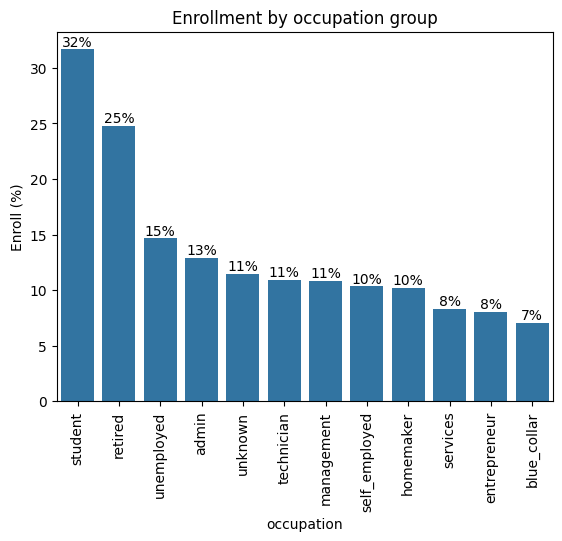

In [18]:
# occupation
chi_square_test(train, 'occupation', 'enroll')
plot_category_percentages(train, 'occupation', 'enroll_binary')

### Marital Status
We see that unknown and single clients tend to enroll more than divorced and married clients. However, unknown statuses are few. `Marital_status` is significantly associated with enrolling.

Chi-x^2 Test P-Value: 5.591152874214814e-22 | Association


enroll,no,yes
marital_status,,
divorced,3319,380
married,17972,2034
single,7892,1293
unknown,50,10


C:\Users\Troy\AppData\Local\Temp\ipykernel_20744\730575341.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


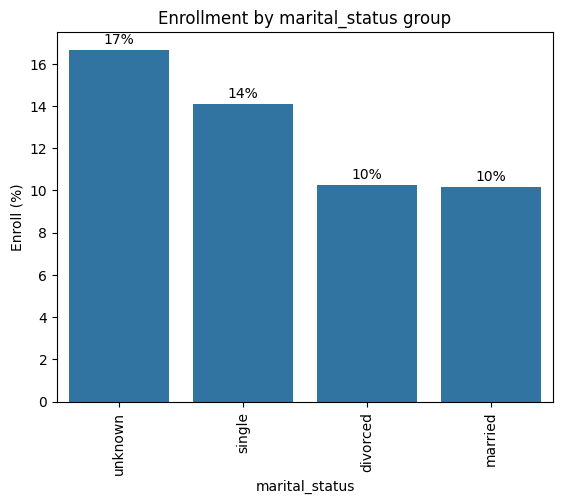

In [19]:
chi_square_test(train, 'marital_status', 'enroll')
plot_category_percentages(train, 'marital_status', 'enroll_binary')

### Education
Illiterate and clients with unknown education have the highest enrollment, but are few in numbers. College degrees also tend to have higher enrollments. Clients with basic education tend to enroll the least. The Chi-squared test shows significance. 

Chi-x^2 Test P-Value: 3.570509449575631e-28 | Association


enroll,no,yes
education_level,,
basic,9086,888
college_degree,8400,1343
high_school,6760,808
illiterate,11,4
professional_training,3782,471
unknown,1194,203


C:\Users\Troy\AppData\Local\Temp\ipykernel_20744\730575341.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


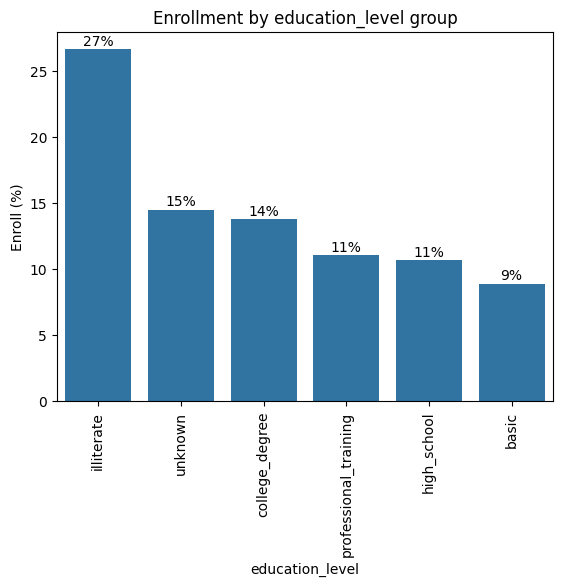

In [20]:
chi_square_test(train, 'education_level', 'enroll')
plot_category_percentages(train, 'education_level', 'enroll_binary')

### Credit in Default
Clients that are willing to disclose their status of non-delinquency enrolled more than clients with an unknown default status. The chi-squared-test is ignored because 2 of the observed values are > 5.

Chi-x^2 Test P-Value: 4.3493791750588967e-72 | Association


enroll,no,yes
credit_in_default,,
no,22676,3361
unknown,6555,356
yes,2,0


C:\Users\Troy\AppData\Local\Temp\ipykernel_20744\730575341.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


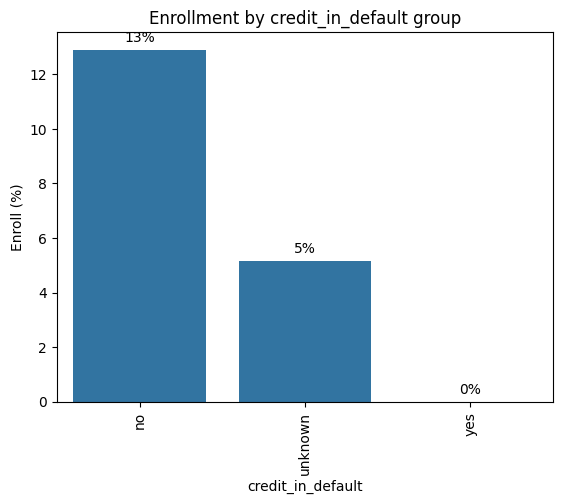

In [21]:
chi_square_test(train, 'credit_in_default', 'enroll')
plot_category_percentages(train, 'credit_in_default', 'enroll_binary')

### Housing Loan
We see no association between between home loan possession and client enrollment.

Chi-x^2 Test P-Value: 0.11385610636487235 | No Association


enroll,no,yes
housing_loan,,
no,13293,1624
unknown,704,89
yes,15236,2004


C:\Users\Troy\AppData\Local\Temp\ipykernel_20744\730575341.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


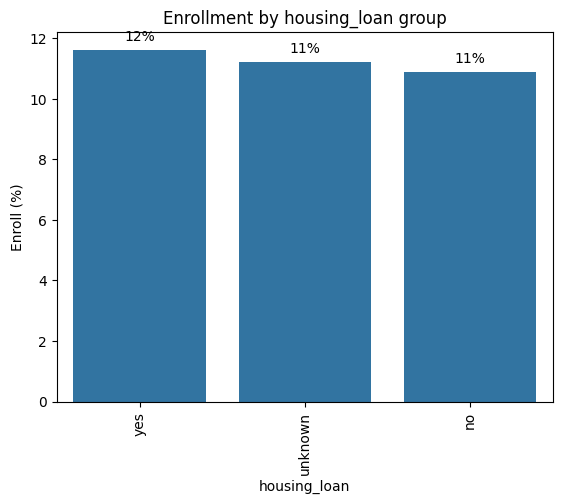

In [22]:
chi_square_test(train, 'housing_loan', 'enroll')
plot_category_percentages(train, 'housing_loan', 'enroll_binary')

### Personal Loan
We see no association between between personal loan possession and client enrollment.

Chi-x^2 Test P-Value: 0.9581507231170548 | No Association


enroll,no,yes
personal_loan,,
no,24065,3067
unknown,704,89
yes,4464,561


C:\Users\Troy\AppData\Local\Temp\ipykernel_20744\730575341.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


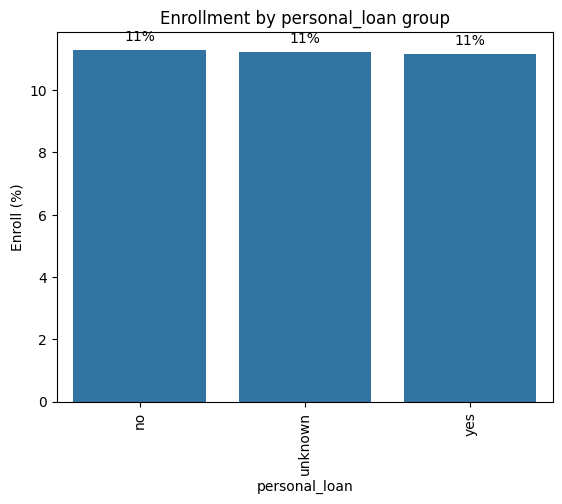

In [23]:
chi_square_test(train, 'personal_loan', 'enroll')
plot_category_percentages(train, 'personal_loan', 'enroll_binary')

### Contact Channel
Clients contacted through email enroll more than those that are called. There is a significant association between contact channel and enrollment.

Chi-x^2 Test P-Value: 2.2231963836060572e-145 | Association


enroll,no,yes
contact_channel,,
email,17892,3075
phone,11341,642


C:\Users\Troy\AppData\Local\Temp\ipykernel_20744\730575341.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


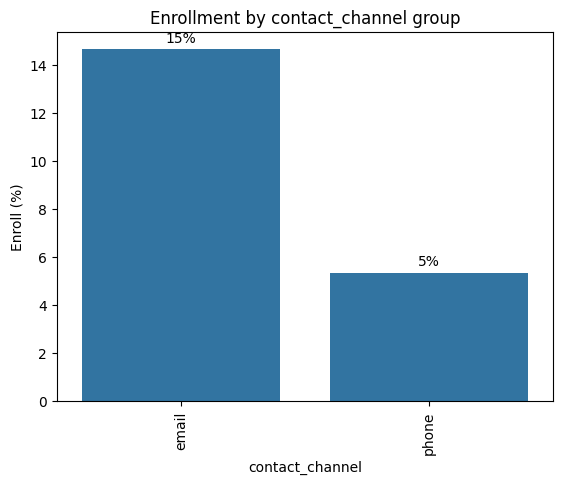

In [24]:
chi_square_test(train, 'contact_channel', 'enroll')
plot_category_percentages(train, 'contact_channel', 'enroll_binary')

### Month
Though there are many months where enrollment is more than 40%, those months tend to have the least amount of clients. Additionally, May and July have lower enrollment. There is a strong association between months and enrollment.

Chi-x^2 Test P-Value: 0.0 | Association


enroll,no,yes
month,,
apr,1691,418
aug,4438,538
dec,71,73
jul,5230,505
jun,3770,459
mar,209,217
may,10290,717
nov,2964,332
oct,322,247


C:\Users\Troy\AppData\Local\Temp\ipykernel_20744\730575341.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


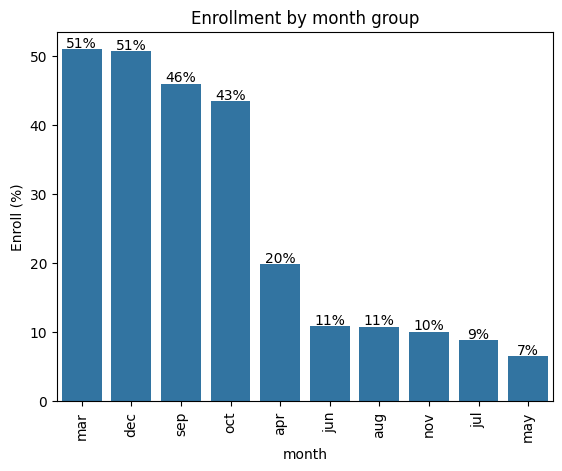

In [25]:
chi_square_test(train, 'month', 'enroll')
plot_category_percentages(train, 'month', 'enroll_binary')

### Day of Week
Wednesdays and Thursdays tend to have more enrollments than the other days and Mondays have the least. Day of week is significantly associated with enrollment.

Chi-x^2 Test P-Value: 0.0002020099018100028 | Association


enroll,no,yes
day_of_week,,
F,5571,683
M,6144,673
R,6110,831
T,5723,753
W,5685,777


C:\Users\Troy\AppData\Local\Temp\ipykernel_20744\730575341.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


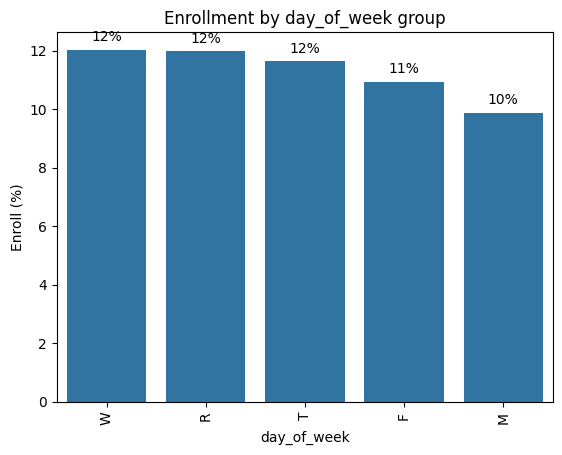

In [26]:
chi_square_test(train, 'day_of_week', 'enroll')
plot_category_percentages(train, 'day_of_week', 'enroll_binary')

### Previous Enrollment
Success in the previous enrollment campaign tends to increase the likelihood of current enrollment. `enroll_previous` is significantly associated with enrollment

Chi-x^2 Test P-Value: 0.0 | Association


enroll,no,yes
enroll_previous,,
does_not_exist,25953,2533
failure,2907,486
success,373,698


C:\Users\Troy\AppData\Local\Temp\ipykernel_20744\730575341.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


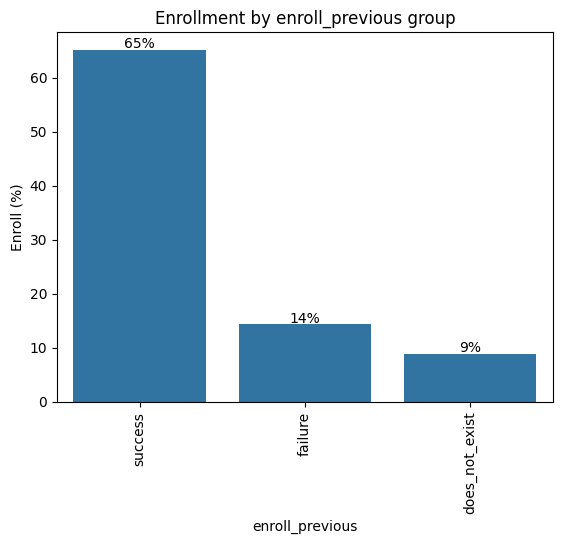

In [27]:
chi_square_test(train, 'enroll_previous', 'enroll')
plot_category_percentages(train, 'enroll_previous', 'enroll_binary')

### Previous Campaign
Participation in the previous enrollment campaign increases likelihood of enrollment. `previous_campaign` is significantly associated with enrollment.

In [28]:
train['previous_campaign'] = train['number_days_since_last'] < 999
chi_square_test(train, 'previous_campaign', 'enroll')

Chi-x^2 Test P-Value: 0.0 | Association


enroll,no,yes
previous_campaign,,
False,28807,2956
True,426,761


In [29]:
del train

## Feature Engineering
The following features were dropped due to lack of significant associations:
1. `number_days_since_last`
2. `housing_loan`
3. `personal_loan`

Continuous features were standardized due to differences in magnitudes. The features are listed:
1. `customer_age`
2. `number_contacts`
3. `number_contacts_previous`
4. `cpi`
5. `cci`

Binary Feature:
1. `previous_campaign`
    - created from the `number_days_since_last` variable

Categorical features are dummy encoded. The features are listed:
1. `occupation`
2. `marital_status`
3. `education_level`
4. `credit_in_default`
5. `contact_channel`
6. `month`
7. `day_of_week`
8. `enroll_previous`

In [31]:
import os
import pickle

train_values = pd.DataFrame()

# 1. continuous
from sklearn.preprocessing import StandardScaler

continuous_cols = [
    'customer_age', 'number_contacts',
    'number_contacts_previous', 'cpi', 'cci']
continuous_vars = raw_train[continuous_cols]
continuous_vars

std_scaler = StandardScaler()
train_values[continuous_cols] = pd.DataFrame(
    std_scaler.fit_transform(continuous_vars),
    columns=continuous_cols
)

# save standardizer
if not os.path.isdir('./models'):
    os.mkdir("./models")

with open('./models/std_scaler.pkl', 'wb') as f:
    pickle.dump(std_scaler, f)

# 2. Add Binary
train_values.loc[:, 'enroll'] = raw_train['enroll'] == 'yes'
train_values['previous_campaign'] = raw_train['number_days_since_last'] < 999
train_values['age_above_60'] = raw_train['customer_age'] > 60
train_values['cpi_below_92.75'] = raw_train['cpi'] < 92.75

train_values

# 3. Add Categoricals
def create_dummy_cols(col: str, data: pd.DataFrame, include_na: bool = False) -> pd.DataFrame:
    dumb_data = pd.get_dummies(
        data[col],
        drop_first=True,
        prefix=col,
        prefix_sep='_',
        dummy_na=include_na)
    
    return dumb_data

categorical_cols = [
    'occupation', 'marital_status', 'education_level', 'credit_in_default',
    'contact_channel', 'month', 'day_of_week', 'enroll_previous']

for col in categorical_cols:
    dumb_data = create_dummy_cols(col, raw_train)
    train_values = pd.concat([train_values, dumb_data], axis=1, sort=False)

train_values


,customer_age,number_contacts,number_contacts_previous,cpi,cci,enroll,previous_campaign,age_above_60,cpi_below_92.75,occupation_blue_collar,...,month_may,month_nov,month_oct,month_sep,day_of_week_M,day_of_week_R,day_of_week_T,day_of_week_W,enroll_previous_failure,enroll_previous_success
0,-0.005305,0.516234,-0.348174,1.539633,-0.279981,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,-0.871206,-0.560637,-0.348174,-0.226703,0.952798,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,-0.005305,-0.201680,-0.348174,0.724800,0.887915,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
3,0.475751,0.875191,-0.348174,0.724800,0.887915,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
4,-1.159840,-0.560637,-0.348174,0.593320,-0.474631,True,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32945,1.534074,-0.560637,-0.348174,0.724800,0.887915,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
32946,1.053018,-0.560637,-0.348174,-0.226703,0.952798,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
32947,-0.197728,0.157277,-0.348174,-1.179935,-1.231601,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
32948,-1.063629,0.157277,-0.348174,-1.179935,-1.231601,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False


## Feature selection

There are a few features that are correlated with one another, but are expected and might not have much impact on the classifier. E.g. Correlation between age and being retired, negative correlation between email usage and age. Further exploration into interaction variables would be suggested for model improvements.

<Axes: >

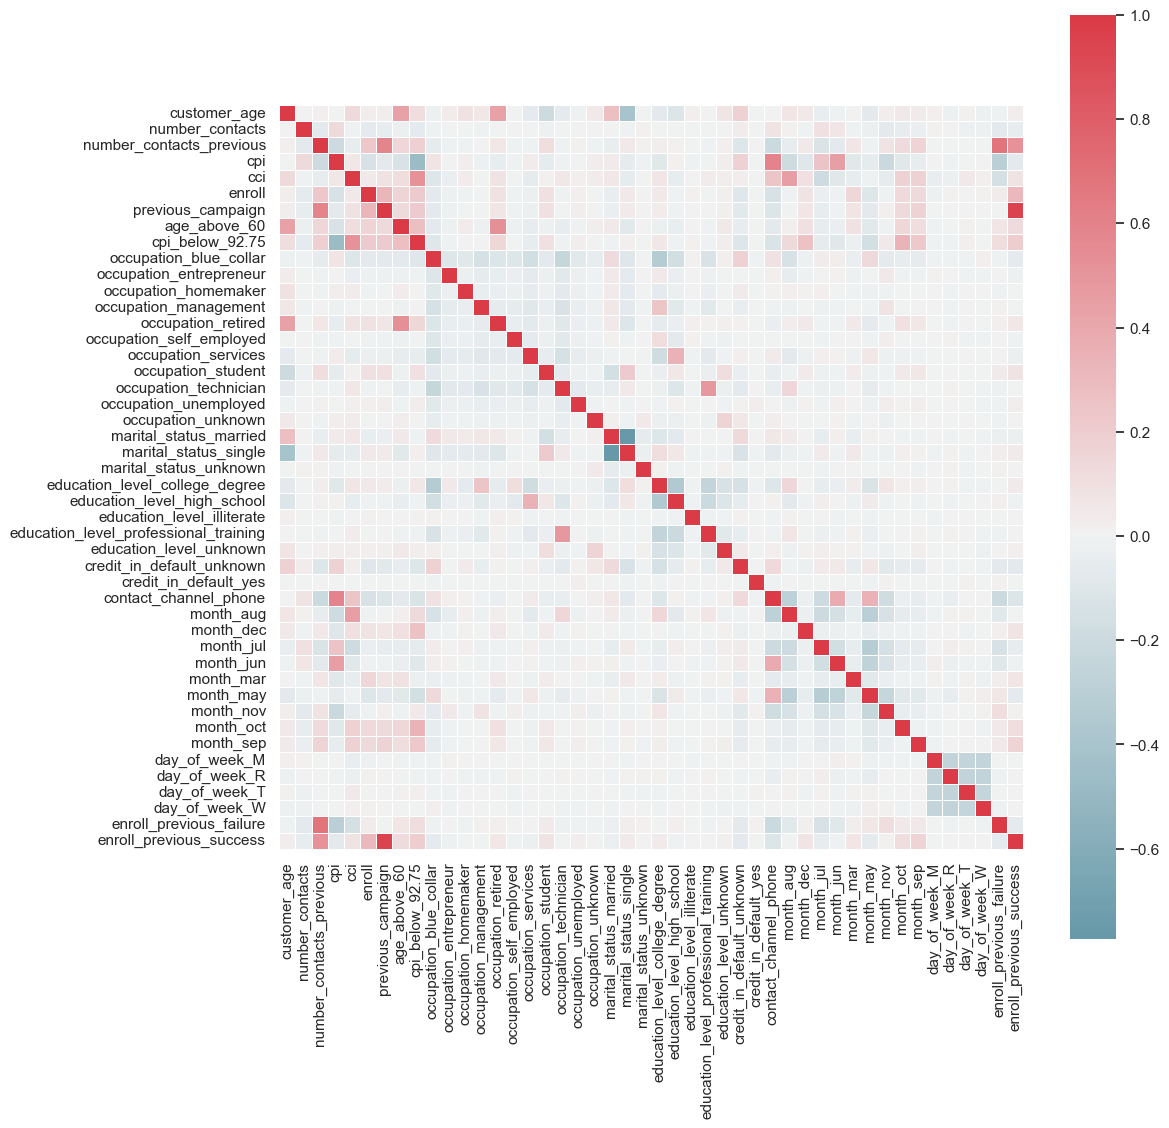

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')

corr = train_values.corr()

plt.figure(figsize=(12,12))
sns.set_theme(font_scale=1)
sns.heatmap(
    data=corr,
    center=0,
    cmap=sns.diverging_palette(220, 10, as_cmap=True), 
    square=True,
    linewidth=0.5)

### L1 Features Selection
A logistic regression with L1 regularization was implemented to select features that would best contribute to a model dividing the feature space in a linear fashion. The threshold for `coefs_squared` was set to 0.05 for retaining the feature, but this is also a hyperparameter that can be tuned.

In [33]:
# Feature selection using L1
from sklearn.linear_model import LogisticRegression

exploratory_LR = LogisticRegression(penalty='l1', fit_intercept=False, solver='liblinear', random_state=random_state)
exploratory_LR.fit(train_values.drop(columns=['enroll']), train_values['enroll'])
exploratory_results = pd.DataFrame({'feature': train_values.drop(columns=['enroll']).columns})
exploratory_results['coefs'] = exploratory_LR.coef_[0]
exploratory_results['coefs_squared'] = exploratory_results['coefs']**2
l1_results = exploratory_results.sort_values(
    by='coefs_squared',
    ascending=False, ignore_index=True)

important_var_l1 = l1_results[l1_results['coefs_squared'] > 0.05]
l1_selected_features = important_var_l1['feature'].to_list()
display(important_var_l1)

,feature,coefs,coefs_squared
0,month_aug,-1.629873,2.656485
1,month_nov,-1.525870,2.328278
2,month_jul,-1.494179,2.232570
3,cpi_below_92.75,1.421022,2.019304
4,contact_channel_phone,-1.414673,2.001298
5,previous_campaign,1.312594,1.722902
6,month_may,-1.042718,1.087261
7,month_mar,0.846106,0.715896
8,education_level_illiterate,0.683395,0.467028
9,month_oct,-0.662028,0.438281


### Random Forest Features Selection
An out-of-the-box rf model was implemented to select features that would best contribute to a model dividing the feature space in a orthogonal fashion. The threshold for `Importance` was set to 0.01 for retaining the feature, but this is also a hyperparameter that can be tuned.

In [34]:
# Feature selection using Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=random_state)
rf.fit(train_values.drop(columns=['enroll']), train_values['enroll'])

rf_results = pd.DataFrame({
    'Features': train_values.drop(columns=['enroll']). columns,
    'Importance': rf.feature_importances_
})

rf_results = rf_results.sort_values(by='Importance', ascending=False, ignore_index=True)
important_var_rf = rf_results[rf_results['Importance'] > 0.01]
rf_selected_features = important_var_rf['Features'].to_list()
display(important_var_rf)

,Features,Importance
0,customer_age,0.260023
1,number_contacts,0.113775
2,cci,0.054719
3,cpi,0.054330
4,previous_campaign,0.045734
5,enroll_previous_success,0.035629
6,number_contacts_previous,0.027122
7,day_of_week_R,0.022793
8,day_of_week_M,0.022484
9,day_of_week_W,0.022299


## Hyperparameter Tuning

Hyperparameters were tuned using GridSearchCV for both L1 selected features and random forest selected features. Specifically, the hyperparameter tuning consisted on testing parameters using a 5-fold cross-validation using F1 as the scoring metric. This was done because our target variable is unbalanced and reducing Type II error is the focus. Next, the prediction threshold is analyzed using accuracy, precision, recall, and F1 metrics. The prediction threshold selection depended on maximizing recall, reducing accuracy loss, and if class weights were used during model creation.

The following models were created to best predict client enrollment:
1. Logistic Regression: Parametric classifier
    - Uses L1 selected features
    - Threshold: 0.5
2. KNN Classifier: Non-parametric proximity-based classifier
    - Uses L1 selected features
    - Threshold: 0.11
3. XGBoosted Classifier: Non-parametric tree-based classifier
    - Uses Random Forest selected features
    - Threshold: 0.5

The results are consolidated here:
| Model | Threshold | Accuracy | Precision | Recall | F1 |
| --- | --- | --- | --- | --- | --- |
| Logistic Regression | 0.5 | 0.8408 | 0.3656 | 0.5588 | 0.5588 |
| KNN Classifier | 0.11 | 0.693 | 0.2075 | 0.6084 | 0.6084 |
| XGBoost Classifier | 0.5 | 0.8373 | 0.367 | 0.6053 | 0.6053 |

The XGBoosted Classifier performed the best. Though the XGBoosted model yields a slightly lower accuracy when compared to the Logestic Regression Classifier, the recall is increased by 5%. Moving forward, only teh KNN and XGBoost models will proceed.

In [35]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from statistics import mean
from typing import Any, List

def cv(
    features: pd.DataFrame,
    labels: pd.Series,
    cv: int = 5,
    threshold: float = 0.5,
    model: Any | None = None,
    random_state: int = 13
) -> pd.DataFrame:
    # initialize the splitting
    folds = RepeatedKFold(n_splits = cv, random_state=random_state)
    
    # create containers
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    # begin cv
    for train_index, test_index in folds.split(features, labels):
        # initialize logistic regressor
        if model == None:
            model_cl = LogisticRegression(
                max_iter = 400,
                random_state = random_state
            )
            
        if model != None:
            model_cl = model
        
        # split data
        train_features = features.iloc[train_index, :]
        test_features = features.iloc[test_index, :]
        train_labels = labels.iloc[train_index]
        test_labels = labels.iloc[test_index]
        
        # train model
        model_cl.fit(train_features, train_labels)
        
        # predict
        pred_prob = model_cl.predict_proba(test_features)
        pred = [int(i > threshold) for i in pred_prob[:, 1]]
        
        # scoring
        accuracy.append(accuracy_score(test_labels, pred))
        precision.append(precision_score(test_labels, pred))
        recall.append(recall_score(test_labels, pred))
        f1.append(f1_score(test_labels, pred))

    results =  pd.DataFrame({
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": recall
    })
    
    return results 


def threshold_testing(
    features: pd.DataFrame,
    labels: pd.Series,
    model: Any,
    model_name: str,
    threshold_values: List[float]
) -> pd.DataFrame:
    threshold_performance = []
    for threshold_value in threshold_values:
        # get AUC measures for theshold
        results = cv(
            features,
            labels,
            threshold=threshold_value,
            model=model)

        # organize results
        mean_results = results.mean(axis = 0)
        full_metric = [
            model_name,
            threshold_value, 
            round(mean_results["accuracy"], 4),
            round(mean_results['precision'], 4),
            round(mean_results['recall'], 4),
            round(mean_results['f1'], 4)
        ]

        # add to container        
        threshold_performance = np.concatenate(
            (threshold_performance, full_metric), 
            axis = 0
        )
        
    threshold_performance_df = pd.DataFrame(
        data = threshold_performance.reshape((len(threshold_values), 6)),
        columns = ["Model", "Threshold", "accuracy", "precision", "recall", "f1"]
    )
        
    return threshold_performance_df

### Logistic Regression

Max iterations parameter tuning stopped at 10 because convergence issues begin below 10.

In [64]:
# Logistic regression - with l1 feature selection
from sklearn.model_selection import GridSearchCV

# Initialize model
log_model = LogisticRegression()

# param_grid
log_parameters = [{
    "C": [0.01, 0.03, 0.1, 0.3, 1, 3, 10],
    "max_iter": [10, 15, 20],
    'solver': ['liblinear'],
    'penalty': ['l2'],
    'class_weight': [{0:0.12, 1:0.88}],
    "random_state": [random_state]
}]

# initialize grid search
grid_search_log = GridSearchCV(
    log_model, 
    log_parameters,
    scoring = "f1",
    cv = 5, 
    n_jobs = 4, 
    verbose = 1
)

# run grid search
print("Results of Training Model with l1 selected features")
%time grid_search_log.fit(train_values[l1_selected_features], train_values['enroll'])
print("Best Parameters: ", grid_search_log.best_params_)
print("Best f1:   ", grid_search_log.best_score_)
best_log_model = grid_search_log
best_log_columns = l1_selected_features

print("\nResults of Training Model with rf selected features")
%time grid_search_log.fit(train_values[rf_selected_features], train_values['enroll'])
print("Best Parameters: ", grid_search_log.best_params_)
print("Best f1:   ", grid_search_log.best_score_)
if best_log_model.best_score_ < grid_search_log.best_score_:
    best_log_model = grid_search_log
    best_log_columns = rf_selected_features

Results of Training Model with l1 selected features
Fitting 5 folds for each of 21 candidates, totalling 105 fits
CPU times: total: 438 ms
Wall time: 2.53 s
Best Parameters:  {'C': 0.03, 'class_weight': {0: 0.12, 1: 0.88}, 'max_iter': 10, 'penalty': 'l2', 'random_state': 13, 'solver': 'liblinear'}
Best f1:    0.4449959903173043

Results of Training Model with rf selected features
Fitting 5 folds for each of 21 candidates, totalling 105 fits
CPU times: total: 328 ms
Wall time: 3.09 s
Best Parameters:  {'C': 3, 'class_weight': {0: 0.12, 1: 0.88}, 'max_iter': 10, 'penalty': 'l2', 'random_state': 13, 'solver': 'liblinear'}
Best f1:    0.35245395544459157


In [65]:
# Find best threshold
log_results = threshold_testing(
    train_values[best_log_columns], 
    train_values['enroll'], 
    LogisticRegression(**best_log_model.best_params_), 
    "Log Reg",
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
)

print(log_results)

     Model Threshold accuracy precision  recall      f1
0  Log Reg       0.1   0.1132    0.1128  0.9999  0.9999
1  Log Reg       0.2   0.2057     0.121  0.9641  0.9641
2  Log Reg       0.3   0.4104    0.1482  0.8899  0.8899
3  Log Reg       0.4   0.6638    0.2125   0.731   0.731
4  Log Reg       0.5   0.8408    0.3656  0.5588  0.5588
5  Log Reg       0.6   0.8634     0.414  0.5054  0.5054
6  Log Reg       0.7   0.8876    0.5022  0.3661  0.3661
7  Log Reg       0.8   0.8906    0.5257   0.313   0.313
8  Log Reg       0.9   0.8945    0.6097  0.1812  0.1812


### KNN Classifier

In [40]:
# Initialize model
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()

# param_grid
knn_parameters = [{
    "weights": ["uniform", "distance"],
    "n_neighbors": [2, 3, 4, 5, 8],
    "leaf_size": [2, 3, 5, 10, 15],
    "metric": ['minkowski'],
    "algorithm": ["auto"],
    "p": [2]
}]

# initialize grid search
grid_search_knn = GridSearchCV(
    knn_model, 
    knn_parameters,
    scoring = "f1",
    cv = 5, 
    n_jobs = 4, 
    verbose = 1
)

# run grid search
print("Results of Training Model with l1 selected features")
%time grid_search_knn.fit(train_values[l1_selected_features], train_values['enroll'])
print("Best Parameters: ", grid_search_knn.best_params_)
print("Best f1:   ", grid_search_knn.best_score_)
best_knn_model = grid_search_knn
best_knn_columns = l1_selected_features

print("\nResults of Training Model with rf selected features")
%time grid_search_knn.fit(train_values[rf_selected_features], train_values['enroll'])
print("Best Parameters: ", grid_search_knn.best_params_)
print("Best f1:   ", grid_search_knn.best_score_)
if best_knn_model.best_score_ < grid_search_knn.best_score_:
    best_knn_model = grid_search_knn
    best_knn_columns = rf_selected_features

Results of Training Model with l1 selected features
Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: total: 1.23 s
Wall time: 41.4 s
Best Parameters:  {'algorithm': 'auto', 'leaf_size': 2, 'metric': 'minkowski', 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best f1:    0.3661288303237925

Results of Training Model with rf selected features
Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: total: 594 ms
Wall time: 39.5 s
Best Parameters:  {'algorithm': 'auto', 'leaf_size': 2, 'metric': 'minkowski', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Best f1:    0.3281216547738255


c:\Users\Troy\Py\Schwab\schwab-client-enrollment-model\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [43]:
# Find best threshold
knn_results = threshold_testing(
    train_values[best_knn_columns], 
    train_values['enroll'], 
    KNeighborsClassifier(**best_knn_model.best_params_), 
    "KNN Classifier",
    [0.08, 0.1, 0.11, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
)

print(knn_results)

             Model Threshold accuracy precision  recall      f1
0   KNN Classifier      0.08    0.693    0.2075  0.6084  0.6084
1   KNN Classifier       0.1    0.693    0.2075  0.6084  0.6084
2   KNN Classifier      0.11    0.693    0.2075  0.6084  0.6084
3   KNN Classifier      0.15    0.693    0.2075  0.6084  0.6084
4   KNN Classifier       0.2   0.8555      0.38  0.4427  0.4427
5   KNN Classifier       0.3   0.8596    0.3897   0.429   0.429
6   KNN Classifier       0.4    0.888    0.5067  0.3163  0.3163
7   KNN Classifier       0.5     0.89     0.525  0.2703  0.2703
8   KNN Classifier       0.6   0.8923    0.5644  0.2007  0.2007
9   KNN Classifier       0.7    0.892    0.5719  0.1726  0.1726
10  KNN Classifier       0.8    0.891     0.581  0.1221  0.1221
11  KNN Classifier       0.9    0.891    0.5871  0.1155  0.1155


### Xgboost Classifier

In [68]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric='logloss')

xgb_parameters = [{
    "max_depth": [4, 5, 7, 9, 12, 15],
    "n_estimators": [40, 50, 60],
    "learning_rate": [0.1, 0.3, 1],
    "min_child_weight": [1, 3, 5],
    "reg_lambda": [0.01, 0.03, 0.1, 0.3], # L2 regularization
    "reg_alpha": [0.01, 0.03, 0.1, 0.3], # L1 regularization
    "scale_pos_weight": [8.09],
    "subsample": [0.8],
    "random_state": [random_state]
}]

grid_search_xgb = GridSearchCV(
    xgb_model, 
    xgb_parameters,
    scoring = "f1", 
    cv = 5,
    n_jobs = 6,                          
    verbose = 1
)

# run grid search
print("Results of Training Model with l1 selected features")
%time grid_search_xgb.fit(train_values[l1_selected_features], train_values['enroll'])
print("Best Parameters: ", grid_search_xgb.best_params_)
print("Best f1:   ", grid_search_xgb.best_score_)
best_xgb_model = grid_search_xgb
best_xgb_columns = l1_selected_features

print("\nResults of Training Model with rf selected features")
%time grid_search_xgb.fit(train_values[rf_selected_features], train_values['enroll'])
print("Best Parameters: ", grid_search_xgb.best_params_)
print("Best f1:   ", grid_search_xgb.best_score_)
if best_xgb_model.best_score_ < grid_search_xgb.best_score_:
    best_xgb_model = grid_search_xgb
    best_xgb_columns = rf_selected_features

Results of Training Model with l1 selected features
Fitting 5 folds for each of 2592 candidates, totalling 12960 fits
CPU times: total: 1min 9s
Wall time: 13min 27s
Best Parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 40, 'random_state': 13, 'reg_alpha': 0.01, 'reg_lambda': 0.3, 'scale_pos_weight': 8.09, 'subsample': 0.8}
Best f1:    0.46255616347072087

Results of Training Model with rf selected features
Fitting 5 folds for each of 2592 candidates, totalling 12960 fits
CPU times: total: 49.6 s
Wall time: 13min 47s
Best Parameters:  {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 40, 'random_state': 13, 'reg_alpha': 0.3, 'reg_lambda': 0.03, 'scale_pos_weight': 8.09, 'subsample': 0.8}
Best f1:    0.4651300602689335


In [69]:
# Find best threshold
from xgboost import XGBClassifier

xgb_results = threshold_testing(
    features=train_values[best_xgb_columns], 
    labels=train_values['enroll'], 
    model=XGBClassifier(
        eval_metric='logloss',
        **best_xgb_model.best_params_
    ),
    model_name="XGBoost Classifier",
    threshold_values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
)

print(xgb_results)

                Model Threshold accuracy precision  recall      f1
0  XGBoost Classifier       0.1   0.1128    0.1128     1.0     1.0
1  XGBoost Classifier       0.2    0.122    0.1135  0.9959  0.9959
2  XGBoost Classifier       0.3   0.3955    0.1463  0.9004  0.9004
3  XGBoost Classifier       0.4   0.7342     0.256  0.7075  0.7075
4  XGBoost Classifier       0.5   0.8373     0.367  0.6053  0.6053
5  XGBoost Classifier       0.6   0.8609    0.4151   0.568   0.568
6  XGBoost Classifier       0.7   0.8791    0.4664  0.4975  0.4975
7  XGBoost Classifier       0.8    0.895    0.5615  0.3165  0.3165
8  XGBoost Classifier       0.9   0.8992    0.7188  0.1742  0.1742


## Model Creation

In [72]:
# Logistic Regression
log_classifier_model = LogisticRegression(**best_log_model.best_params_)
log_classifier_model.fit(train_values[best_log_columns], train_values['enroll'])

LogisticRegression(C=3, class_weight={0: 0.12, 1: 0.88}, max_iter=10,
                   random_state=13, solver='liblinear')

In [73]:
# XGBoosted Classifier
xgb_classifier_model = XGBClassifier(
    eval_metric='logloss',
    **best_xgb_model.best_params_)
xgb_classifier_model.fit(train_values[best_xgb_columns], train_values['enroll'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=40,
              n_jobs=None, num_parallel_tree=None, random_state=13, ...)

## Get results

In [74]:
# Transform test data
test_values = pd.DataFrame()

# 1. continuous
continuous_cols = [
    'customer_age', 'number_contacts',
    'number_contacts_previous', 'cpi', 'cci']
continuous_vars = raw_test[continuous_cols]
continuous_vars

test_values[continuous_cols] = pd.DataFrame(
    std_scaler.transform(continuous_vars),
    columns=continuous_cols
)

# 2. Add Binary
test_values.loc[:, 'enroll'] = raw_test['enroll'] == 'yes'
test_values['previous_campaign'] = raw_test['number_days_since_last'] < 999
test_values['age_above_60'] = raw_test['customer_age'] > 60
test_values['cpi_below_92.75'] = raw_test['cpi'] < 92.75

# 3. Add Categoricals
def create_dummy_cols(col: str, data: pd.DataFrame, include_na: bool = False) -> pd.DataFrame:
    dumb_data = pd.get_dummies(
        data[col],
        drop_first=True,
        prefix=col,
        prefix_sep='_',
        dummy_na=include_na)
    
    return dumb_data

categorical_cols = [
    'occupation', 'marital_status', 'education_level', 'credit_in_default',
    'contact_channel', 'month', 'day_of_week', 'enroll_previous']

for col in categorical_cols:
    dumb_data = create_dummy_cols(col, raw_test)
    test_values = pd.concat([test_values, dumb_data], axis=1, sort=False)

test_values.head()

,customer_age,number_contacts,number_contacts_previous,cpi,cci,enroll,previous_campaign,age_above_60,cpi_below_92.75,occupation_blue_collar,...,month_may,month_nov,month_oct,month_sep,day_of_week_M,day_of_week_R,day_of_week_T,day_of_week_W,enroll_previous_failure,enroll_previous_success
0,-1.544685,0.157277,-0.348174,-1.179935,-1.231601,False,False,False,False,True,...,True,False,False,False,True,False,False,False,False,False
1,0.379539,-0.560637,-0.348174,-0.226703,0.952798,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,1.822708,-0.201680,-0.348174,-0.226703,0.952798,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,1.534074,0.157277,-0.348174,0.593320,-0.474631,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,-0.774995,-0.560637,-0.348174,-2.377099,1.969301,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False


In [92]:
model_results = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": []}

#### Baseline Model (Simple Majority Classifier)

In [93]:
import numpy as np

baseline_pred = np.zeros_like(test_values['enroll'])
model_results['Model'].append('Majority Classifier')
model_results['Accuracy'].append(accuracy_score(baseline_pred, test_values['enroll']))
model_results['Precision'].append(precision_score(baseline_pred, test_values['enroll']))
model_results['Recall'].append(recall_score(baseline_pred, test_values['enroll']))
model_results['F1'].append(f1_score(baseline_pred, test_values['enroll']))

c:\Users\Troy\Py\Schwab\schwab-client-enrollment-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Logistic Regression

In [94]:
log_test_probabilities = log_classifier_model.predict_proba(test_values[best_log_columns])
log_test_predictions = [int(i >= 0.5) for i in log_test_probabilities[:, 1]]

model_results['Model'].append('Logistic Regression')
model_results['Accuracy'].append(accuracy_score(log_test_predictions, test_values['enroll']))
model_results['Precision'].append(precision_score(log_test_predictions, test_values['enroll']))
model_results['Recall'].append(recall_score(log_test_predictions, test_values['enroll']))
model_results['F1'].append(f1_score(log_test_predictions, test_values['enroll']))

#### XGBoost Classifier

In [95]:
xgb_test_probabilities = xgb_classifier_model.predict_proba(test_values[best_xgb_columns])
xgb_test_predictions = [int(i >= 0.5) for i in xgb_test_probabilities[:, 1]]

model_results['Model'].append('XGBoost Classifier')
model_results['Accuracy'].append(accuracy_score(xgb_test_predictions, test_values['enroll']))
model_results['Precision'].append(precision_score(xgb_test_predictions, test_values['enroll']))
model_results['Recall'].append(recall_score(xgb_test_predictions, test_values['enroll']))
model_results['F1'].append(f1_score(xgb_test_predictions, test_values['enroll']))

## Compare the models (Conclusion)

#### Performance
- Though the XGBoost Classifier and the Logistic Regression Classifier had marginally lower accuracy, the models proved the best for maximizing Precision and Recall.
- Compared to the Majority Classifier, we sacrificed 4% accuracy for a 38% increase in potential enrollee identification.

#### Limitations to to model performance
- Data/Concept drift
    - The data with values values outside the distribution of our training data will decrease model performance
    - If features are no longer associated or correlated, the performance will decrease
- Nulls will limit performance

#### Improvements
- Explore interactions between features
- Tune feature selection threshold value
- Explore a larger range for model hyperparameter tuning and perhaps use BayesSearchCV
- Find more data to supplement the categories with few observations

In [96]:
import pandas as pd
pd.DataFrame(model_results)

,Model,Accuracy,Precision,Recall,F1
0,Majority Classifier,0.887958,0.000000,0.000000,0.000000
1,Logistic Regression,0.844744,0.595883,0.377747,0.462379
2,XGBoost Classifier,0.844258,0.621885,0.380637,0.472234
